In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Exploratory Data Analysis

In [ ]:
import spacy

In [3]:
df = pd.read_csv("../Documents/Coding/ComplaintsData/Complaints-2022-Dataset.csv")

In [4]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/24/22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,None,"EQUIFAX, INC.",FL,32258,None,Consent not provided,Web,08/24/22,Closed with explanation,Yes,NaN,5910626
1,10/06/22,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Someone has used my personal information to ob...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IN,46260,None,Consent provided,Web,10/06/22,Closed with non-monetary relief,Yes,NaN,6056393
2,08/24/22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TN,38135,None,Consent not provided,Web,08/24/22,Closed with non-monetary relief,Yes,NaN,5913937
3,10/06/22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,My name is XXXX XXXX XXXX this complaint is no...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NY,13905,None,Consent provided,Web,10/06/22,Closed with explanation,Yes,NaN,6056396
4,10/10/22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I took a road trip with my friend and we used ...,None,"EQUIFAX, INC.",CA,91752,None,Consent provided,Web,10/10/22,Closed with explanation,Yes,NaN,6068582


In [5]:
df = df.dropna(subset = 'Consumer complaint narrative')

In [6]:
#Columns in dataframe
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [7]:
#Checking data-types and null values for each feature of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337220 entries, 1 to 800401
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date received                 337220 non-null  object 
 1   Product                       337220 non-null  object 
 2   Sub-product                   337220 non-null  object 
 3   Issue                         337220 non-null  object 
 4   Sub-issue                     337220 non-null  object 
 5   Consumer complaint narrative  337220 non-null  object 
 6   Company public response       337220 non-null  object 
 7   Company                       337220 non-null  object 
 8   State                         337220 non-null  object 
 9   ZIP code                      337220 non-null  object 
 10  Tags                          337220 non-null  object 
 11  Consumer consent provided?    337220 non-null  object 
 12  Submitted via                 337220 non-nul

## Dates the complaints were received versus sent

In [8]:
#Date complaint was sent does not always match date received 
sum(df['Date received'] == df['Date sent to company'])

318357

In [17]:
#There is not a clear pattern as to which dates were delayed in being sent by the CFPB to companies
df[~(df['Date received'] == df['Date sent to company'])][['Date received', 'Date sent to company']]

,Date received,Date sent to company
21,05/23/22,2022-06-09
120,08/20/22,2022-09-14
261,12/23/22,2023-01-13
338,10/06/22,2022-10-20
506,10/05/22,2022-10-06
...,...,...
800231,08/23/22,2022-09-20
800237,09/23/22,2022-10-17
800250,07/16/22,2022-08-03
800284,08/07/22,2022-08-08


In [18]:
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])

In [19]:
df['Month sent to company'] = df['Date sent to company'].map(lambda x: x.month)

## Complaints visualized over time

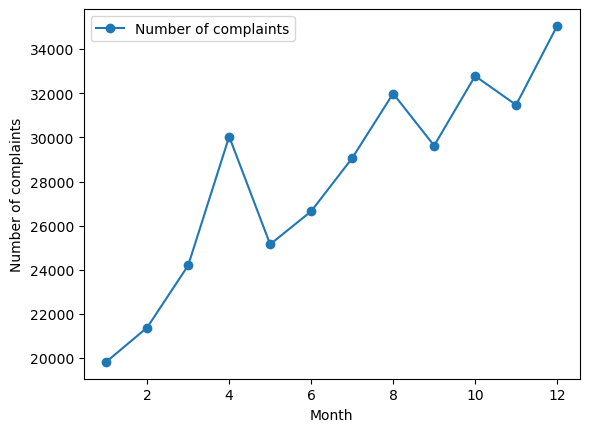

In [20]:
#Total number of complaints by month sent to company
plt.plot(df['Month sent to company'].value_counts().sort_index().index, df['Month sent to company'].value_counts().sort_index(), marker='o', linestyle='-', label='Number of complaints')
plt.xlabel('Month')
plt.ylabel('Number of complaints')
plt.legend(loc='best')
plt.show()

## Product/Sub-product Patterns 

<Axes: >

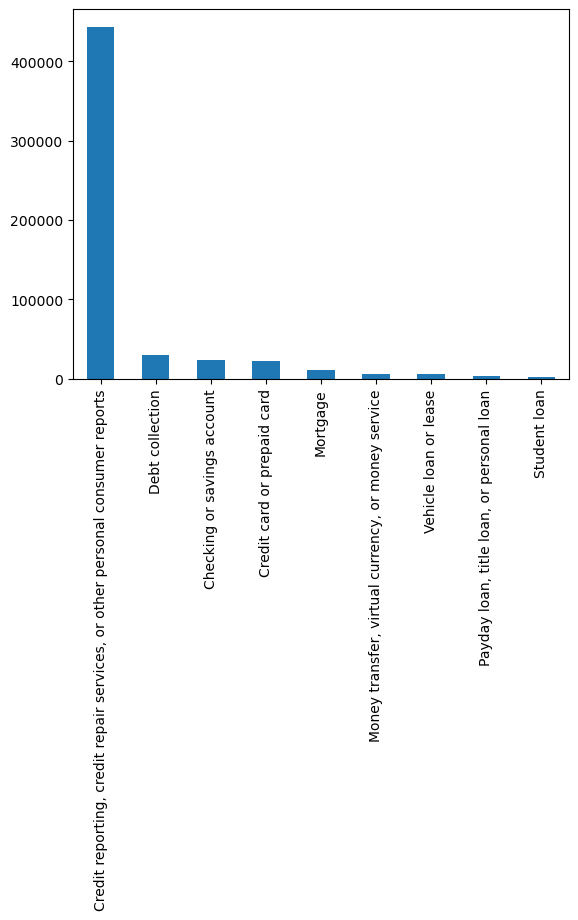

In [26]:
#Majority of complaints related to credit reporting/repair services/personal consumer reports
df['Product'].value_counts().plot(kind = 'bar')

In [27]:
#Number of each Product complaint by State
pivot_df = pd.pivot_table(data = df,
                         index = 'Product',
                         columns = 'State',
                         fill_value = 0,
                         aggfunc = 'count')
pivot_df

Company                    \
State                                                   AA  AE  AK    AL  AP   
Product                                                                        
Checking or savings account                              0   6  21   208   4   
Credit card or prepaid card                              0  11  36   206   5   
Credit reporting, credit repair services, or ot...       0  46  87  4681  33   
Debt collection                                          1   9  30   496   5   
Money transfer, virtual currency, or money service       0   2   6    67   3   
Mortgage                                                 0   4  26   123   2   
Payday loan, title loan, or personal loan                0   3   2    57   0   
Student loan                                             0   6  10    37   0   
Vehicle loan or lease                                    0   0   2    58   0   

                                                                          \
State                                                 AR AS    AZ     CA   
Product                                                                    
Checking or savings account                           96  0   441   2664   
Credit card or prepaid card                          101  0   553   3112   
Credit reporting, credit repair services, or ot...  1441  0  4176  23156   
Debt collection                                      198  0   677   2833   
Money transfer, virtual currency, or money service    35  1   174   1125   
Mortgage                                              59  0   249   1620   
Payday loan, title loan, or personal loan             18  0    85    332   
Student loan                                          31  0    88    434   
Vehicle loan or lease                                 49  0   138    490   

                                                          ... ZIP code  \
State                                                 CO  ...       TX   
Product                                                   ...            
Checking or savings account                          300  ...     1558   
Credit card or prepaid card                          376  ...     1662   
Credit reporting, credit repair services, or ot...  1433  ...    23920   
Debt collection                                      405  ...     3501   
Money transfer, virtual currency, or money service   157  ...      628   
Mortgage                                             318  ...      993   
Payday loan, title loan, or personal loan             50  ...      359   
Student loan                                          85  ...      272   
Vehicle loan or lease                                 57  ...      445   

                                                                                         \
State                                              UNITED STATES MINOR OUTLYING ISLANDS   
Product                                                                                   
Checking or savings account                                                           3   
Credit card or prepaid card                                                           4   
Credit reporting, credit repair services, or ot...                                   20   
Debt collection                                                                       8   
Money transfer, virtual currency, or money service                                    1   
Mortgage                                                                              2   
Payday loan, title loan, or personal loan                                             0   
Student loan                                                                          0   
Vehicle loan or lease                                                                 0   

                                                                             \
State                                                UT    VA  VI  VT    WA   
Product                              

In [38]:
#Highest Product Complaint by State
pivot_df.idxmax()

          State
Company   AA                                         Debt collection
          AE       Credit reporting, credit repair services, or o...
          AK       Credit reporting, credit repair services, or o...
          AL       Credit reporting, credit repair services, or o...
          AP       Credit reporting, credit repair services, or o...
                                         ...                        
ZIP code  VT       Credit reporting, credit repair services, or o...
          WA       Credit reporting, credit repair services, or o...
          WI       Credit reporting, credit repair services, or o...
          WV       Credit reporting, credit repair services, or o...
          WY       Credit reporting, credit repair services, or o...
Length: 1037, dtype: object

<Axes: >

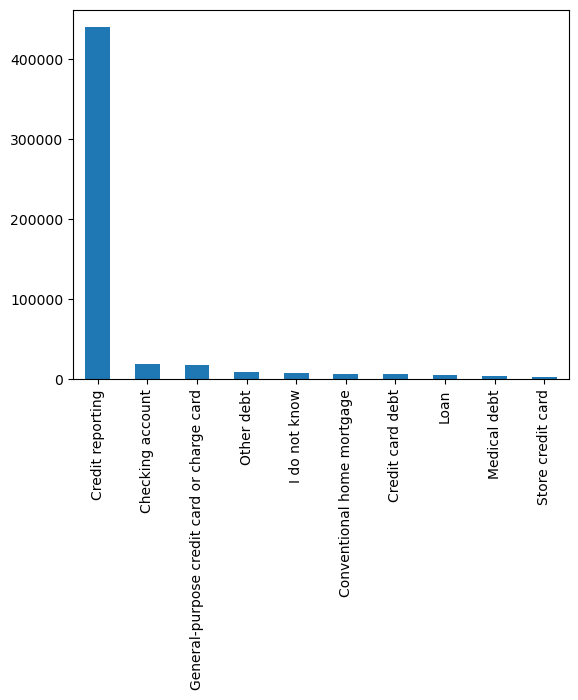

In [30]:
#Sub-product identified based on the product
df['Sub-product'].value_counts()[:10].plot(kind = 'bar')

In [40]:
#Number of each Sub-Product complaint by State
pivot2_df = pd.pivot_table(data = df,
                         index = 'Sub-product',
                         columns = 'State',
                         fill_value = 0,
                         aggfunc = 'count')
pivot2_df

Company                             \
State                                           AA  AE  AK    AL  AP    AR AS   
Sub-product                                                                     
Auto debt                                        1   1   0    41   0    13  0   
CD (Certificate of Deposit)                      0   0   0     2   0     2  0   
Check cashing service                            0   0   0     2   0     2  0   
Checking account                                 0   2  14   177   4    82  0   
Conventional home mortgage                       0   0  15    55   2    31  0   
Credit card debt                                 0   0   6    95   1    43  0   
Credit repair services                           0   0   0     7   0     9  0   
Credit reporting                                 0  46  86  4643  33  1422  0   
Debt settlement                                  0   0   0     3   0     1  0   
Domestic (US) money transfer                     0   1   1    19   2     8  0   
FHA mortgage                                     0   1   2    34   0    17  0   
Federal student loan debt                        0   0   2     2   0     2  0   
Federal student loan servicing                   0   5   6    20   0    26  0   
Foreign currency exchange                        0   0   0     0   0     1  1   
General-purpose credit card or charge card       0  10  28   144   5    72  0   
General-purpose prepaid card                     0   0   3    13   0     8  0   
Gift card                                        0   0   0     1   0     0  0   
Government benefit card                          0   0   0     9   0     2  0   
Home equity loan or line of credit (HELOC)       0   0   0     8   0     2  0   
I do not know                                    0   3   5    83   0    43  0   
Installment loan                                 0   1   0    32   0     8  0   
International money transfer                     0   1   3     3   1     2  0   
Lease                                            0   0   0     4   0     8  0   
Loan                                             0   0   2    54   0    41  0   
Medical debt                                     0   1   4   111   1    35  0   
Mobile or digital wallet                         0   0   2    28   0    16  0   
Money order                                      0   0   0     0   0     0  0   
Mortgage debt                                    0   0   1     7   0     1  0   
None                                             0   0   0     0   0     0  0   
Other banking product or service                 0   1   2    10   0     3  0   
Other debt                                       0   1  11   135   1    57  0   
Other personal consumer report                   0   0   1    31   0    10  0   
Other type of mortgage                           0   0   6     8   0     3  0   
Pawn loan                                        0   0   0     0   0     0  0   
Payday loan                                      0   1   0     7   0     5  0   
Payday loan debt                                 0   3   0    20   2     1  0   
Payroll card                                     0   0   1     1   0     0  0   
Personal line of credit                          0   1   2    13   0     4  0   
Private student loan                             0   1   4    17   0     5  0   
Private student loan debt                        0   0   1     2   0     3  0   
Refund anticipation check                        0   0   0     1   0     0  0   
Reverse mortgage                                 0   0   1     0   0     1  0   
Savings account                                  0   3   5    19   0     9  0   
Store credit card                                0   1   4    38   0    19  0   
Student prepaid card                             0   0   0     0   0     0  0   
Title loan                                       0   0   0     5   0     1  0   
Traveler's check or cashier's check              0   0   0     0   0     3

In [41]:
#Closely resembles Product pivot table
pivot2_df.idxmax()

          State
Company   AA              Auto debt
          AE       Credit reporting
          AK       Credit reporting
          AL       Credit reporting
          AP       Credit reporting
                         ...       
ZIP code  VT       Credit reporting
          WA       Credit reporting
          WI       Credit reporting
          WV       Credit reporting
          WY       Credit reporting
Length: 1037, dtype: object

## Issue/Sub-issue Trends

<Axes: >

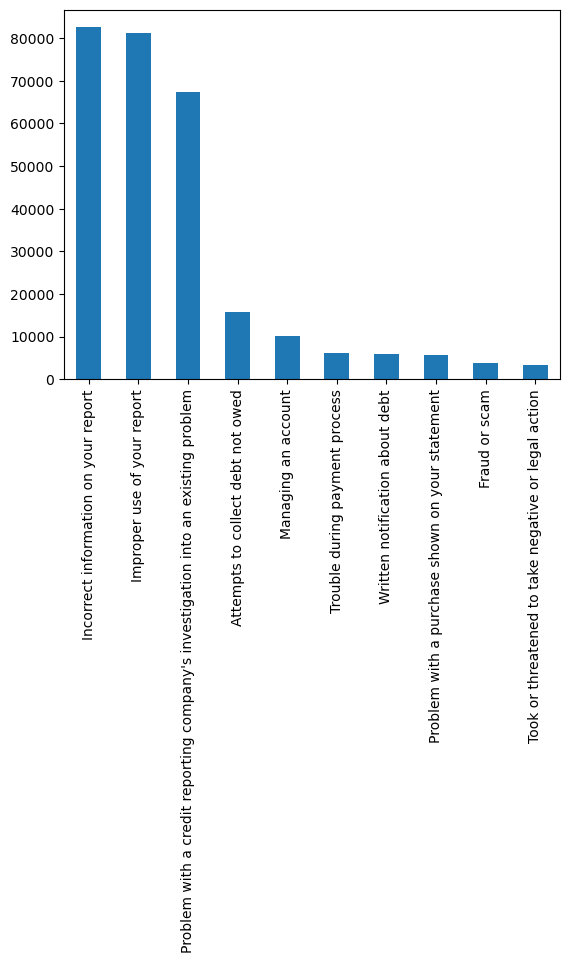

In [47]:
#Top 10 Issue complaints overall
df['Issue'].value_counts()[:10].plot(kind = 'bar')

In [49]:
#Number of complaints by Issue for each State
pivot3_df = pd.pivot_table(data = df,
                          index = 'Issue',
                          columns = 'State',
                          fill_value = 0,
                          aggfunc = 'count')
pivot3_df

Company                    \
State                                                   AA AE AK   AL AP  AR   
Issue                                                                          
Advertising                                              0  0  0    0  0   0   
Advertising and marketing, including promotiona...       0  0  1    9  0   4   
Applying for a mortgage or refinancing an exist...       0  0  6   21  1   6   
Attempts to collect debt not owed                        0  4  9  268  3  97   
Can't contact lender or servicer                         0  0  0    1  0   0   
...                                                    ... .. ..  ... ..  ..   
Vehicle was repossessed or sold the vehicle              0  0  0    1  0   0   
Was approved for a loan, but didn't receive money        0  0  0    0  0   0   
Was approved for a loan, but didn't receive the...       0  0  0    2  0   0   
Written notification about debt                          1  3  1   97  0  37   
Wrong amount charged or received                         0  0  0    1  0   0   

                                                                       ...  \
State                                              AS   AZ    CA   CO  ...   
Issue                                                                  ...   
Advertising                                         0    1     6    2  ...   
Advertising and marketing, including promotiona...  0   24   174   17  ...   
Applying for a mortgage or refinancing an exist...  0   41   227   41  ...   
Attempts to collect debt not owed                   0  312  1504  189  ...   
Can't contact lender or servicer                    0    2     6    0  ...   
...                                                ..  ...   ...  ...  ...   
Vehicle was repossessed or sold the vehicle         0    3     3    0  ...   
Was approved for a loan, but didn't receive money   0    0     0    0  ...   
Was approved for a loan, but didn't receive the...  0    0     5    0  ...   
Written notification about debt                     0  111   478   61  ...   
Wrong amount charged or received                    0    0    11    1  ...   

                                                   ZIP code  \
State                                                    TX   
Issue                                                         
Advertising                                               1   
Advertising and marketing, including promotiona...       76   
Applying for a mortgage or refinancing an exist...      144   
Attempts to collect debt not owed                      1714   
Can't contact lender or servicer                          8   
...                                                     ...   
Vehicle was repossessed or sold the vehicle               4   
Was approved for a loan, but didn't receive money         0   
Was approved for a loan, but didn't receive the...        2   
Written notification about debt                         667   
Wrong amount charged or received                          6   

                                                                                         \
State                                              UNITED STATES MINOR OUTLYING ISLANDS   
Issue                                                                                     
Advertising                                                                           0   
Advertising and marketing, including promotiona...                                    0   
Applying for a mortgage or refinancing an exist...                                    1   
Attempts to collect debt not owed                                                     4   
Can't contact lender or servicer                                                      0   
...                                                                                 ...   
Vehicle was repossessed or sold the vehicle                                           0   
Was approved for a loan, but didn't receive 

In [50]:
#Most common Issue by State
pivot3_df.idxmax()

          State
Company   AA                         Written notification about debt
          AE                    Incorrect information on your report
          AK                    Incorrect information on your report
          AL                             Improper use of your report
          AP                             Improper use of your report
                                         ...                        
ZIP code  VT                    Incorrect information on your report
          WA                             Improper use of your report
          WI                             Improper use of your report
          WV       Problem with a credit reporting company's inve...
          WY                             Improper use of your report
Length: 1037, dtype: object

<Axes: >

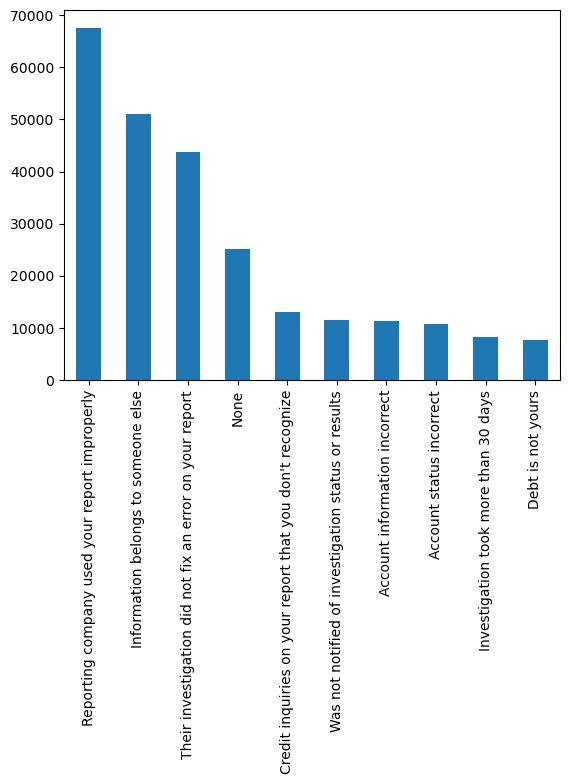

In [54]:
#Top 10 Sub-issues for overall complaints
df['Sub-issue'].value_counts()[:10].plot(kind = 'bar')

In [57]:
#Count of sub-issue for each state
pivot4_df = pd.pivot_table(data = df,
                          index = 'Sub-issue',
                          columns = 'State',
                          fill_value = 0,
                          aggfunc = 'count')
pivot4_df

Company                    \
State                                                   AA AE AK   AL AP  AR   
Sub-issue                                                                      
Account information incorrect                            0  2  9  183  0  72   
Account opened as a result of fraud                      0  1  3    4  0   5   
Account sold or transferred to another company           0  0  0    0  0   0   
Account status incorrect                                 0  9  4  172  5  58   
Add-on products and services                             0  0  1    1  0   0   
...                                                    ... .. ..  ... ..  ..   
Used obscene, profane, or other abusive language         0  0  1    4  0   5   
Was not notified of investigation status or res...       0  2  0  245  0  63   
Was signed up for overdraft on card, but don't ...       0  0  0    0  0   0   
You never received your bill or did not know a ...       0  0  1    3  0   3   
You told them to stop contacting you, but they ...       0  2  1   16  0   3   

                                                                       ...  \
State                                              AS   AZ    CA   CO  ...   
Sub-issue                                                              ...   
Account information incorrect                       0  276  1249   95  ...   
Account opened as a result of fraud                 0   12    69   18  ...   
Account sold or transferred to another company      0    0     4    3  ...   
Account status incorrect                            0  338   971  128  ...   
Add-on products and services                        0    2    14    2  ...   
...                                                ..  ...   ...  ...  ...   
Used obscene, profane, or other abusive language    0    9    24    4  ...   
Was not notified of investigation status or res...  0  191   787   57  ...   
Was signed up for overdraft on card, but don't ...  0    0     0    0  ...   
You never received your bill or did not know a ...  0    8    21    1  ...   
You told them to stop contacting you, but they ...  0   14    35   12  ...   

                                                   ZIP code  \
State                                                    TX   
Sub-issue                                                     
Account information incorrect                          1095   
Account opened as a result of fraud                      98   
Account sold or transferred to another company            2   
Account status incorrect                               1002   
Add-on products and services                              9   
...                                                     ...   
Used obscene, profane, or other abusive language         34   
Was not notified of investigation status or res...     1272   
Was signed up for overdraft on card, but don't ...        0   
You never received your bill or did not know a ...       37   
You told them to stop contacting you, but they ...       76   

                                                                                         \
State                                              UNITED STATES MINOR OUTLYING ISLANDS   
Sub-issue                                                                                 
Account information incorrect                                                         0   
Account opened as a result of fraud                                                   0   
Account sold or transferred to another company                                        0   
Account status incorrect                                                              2   
Add-on products and services                                                          0   
...                                                                                 ...   
Used obscene, profane, or other abusive language                                      0   
Was not notified of investigation status or 

In [58]:
pivot4_df.idxmax()

          State
Company   AA       Didn't receive enough information to verify debt
          AE          Reporting company used your report improperly
          AK                                                   None
          AL          Reporting company used your report improperly
          AP          Reporting company used your report improperly
                                         ...                       
ZIP code  VT                                                   None
          WA                                                   None
          WI          Reporting company used your report improperly
          WV                                                   None
          WY          Reporting company used your report improperly
Length: 1037, dtype: object

In [61]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Month sent to company
1,10/06/22,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Someone has used my personal information to ob...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IN,46260,None,Consent provided,Web,2022-10-06,Closed with non-monetary relief,Yes,NaN,6056393,10
3,10/06/22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,My name is XXXX XXXX XXXX this complaint is no...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NY,13905,None,Consent provided,Web,2022-10-06,Closed with explanation,Yes,NaN,6056396,10
4,10/10/22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I took a road trip with my friend and we used ...,None,"EQUIFAX, INC.",CA,91752,None,Consent provided,Web,2022-10-10,Closed with explanation,Yes,NaN,6068582,10
6,10/06/22,Checking or savings account,Other banking product or service,Problem with a lender or other company chargin...,Transaction was not authorized,XX/XX/XXXX XXXX was taken out of account a XXX...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,320XX,None,Consent provided,Web,2022-10-06,Closed with explanation,Yes,NaN,6056399,10
9,10/06/22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,63119,None,Consent provided,Web,2022-10-06,Closed with non-monetary relief,Yes,NaN,6056152,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800378,08/13/22,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"A couple of months ago, I received a note of c...",None,"EQUIFAX, INC.",CA,95003,None,Consent provided,Web,2022-08-13,Closed with explanation,Yes,NaN,5875698,8
800386,07/17/22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,I have strong reason to believe that as Federa...,None,"EQUIFAX, INC.",AZ,85286,None,Consent provided,Web,2022-07-17,Closed with explanation,Yes,NaN,5780106,7
800390,08/13/22,Checking or savings account,Checking account,Managing an account,Banking errors,Bancorp South has been charging me overdraft f...,None,CADENCE BANK,MS,39564,None,Consent provided,Web,2022-08-13,Closed with monetary relief,Yes,NaN,5876148,8
800392,08/13/22,Credit card or prepaid card,General-purpose credit card or charge card,Getting a credit card,Card opened as result of identity theft or fraud,"Through out XX/XX/2022, my best buy citibank c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11228,None,Consent provided,Web,2022-08-13,Closed with non-monetary relief,Yes,NaN,5872879,8
